In [2]:
from pyspark.sql.types import *

ratings_df_schema = StructType(
    [StructField('asin', StringType()),
    StructField('helpful', ArrayType(IntegerType())),
    StructField('overall', FloatType()),
    StructField('reviewText', StringType()),
    StructField('reviewTime', DateType()),
    StructField('reviewerID', StringType()),
    StructField('summary', StringType())])

# StructField('unixReviewTime', LongType())
# ['asin', 'description', 'title', 'categories']
metadata_df_schema = StructType(
    [StructField('asin', StringType()),
    StructField('description', StringType()),
    StructField('title', StringType()),
    StructField('categories', ArrayType(StringType()))])


In [3]:

#import metadata files

import gzip
from pyspark.sql import Row
from collections import OrderedDict
from datetime import datetime

def parse_metadata(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def create_metadata_df(path):
    metadata = []
    for entry in parse_metadata(path):
        metadata.append(entry)

  #find all keys
    all_keys = []
    for i in range(len(metadata)):
        for key in metadata[i].keys():
            if key not in all_keys:
                all_keys.append(key)
    print(all_keys)
  #['asin', 'categories', 'price', 'related'] in instant videos
  #['asin', 'imUrl', 'description', 'categories', 'title', 'related', 'price', 'salesRank', 'brand'] in electronics
  
  #check number of entries that contains each key
    key_count_dict = {}
    for key in all_keys:
        key_count_dict[key] = 0
    for i in range(len(metadata)):
        for key in all_keys:
            if key in metadata[i].keys():
                key_count_dict[key] += 1
    print(key_count_dict)  
#  {'asin': 498196, 'description': 459470, 'title': 491194, 'price': 389693, 'imUrl': 498021, 'related': 366959, 'salesRank': 128706, 'brand': 142532, 'categories': 498196} for electronics
    discard_missing_info_col = True
    cols_to_keep = ['asin', 'description', 'title', 'categories']
    filtered_metadata = []
    for i in range(len(metadata)):
        keep_col = True
        if discard_missing_info_col:
      #only retain items that contain info for all columns
            cols = [x for x in cols_to_keep if x in metadata[i].keys()]
            if len(cols) != len(cols_to_keep):
                keep_col = False
        if keep_col:
            temp_dict = {}
            for col in cols_to_keep: 
                if col not in metadata[i].keys():
                    temp_dict[col] = None
                elif col == 'categories':#given as array of array so only keeep the inner array
                    temp_dict[col] = metadata[i]['categories'][0]
                else:
                    temp_dict[col] = metadata[i][col]
            filtered_metadata.append(temp_dict)

    return sqlContext.createDataFrame(filtered_metadata, schema = metadata_df_schema)#schema=metadata_df_schema
  

# books_df = create_review_df('/dbfs/tmp/Metadata/Books.json.gz')
#instant_video_meta_df = create_metadata_df('/dbfs/tmp/Metadata/Instant_Video.json.gz')
# movies_df = create_review_df('/dbfs/tmp/Metadata/Movies_and_TV.json.gz')
# cds_df = create_review_df('/dbfs/tmp/Metadata/CDs_and_Vinyl.json.gz')
# instruments_df = create_review_df('/dbfs/tmp/Metadata/Musical_Instruments.json.gz')
# instant_video_df = create_review_df('/dbfs/tmp/Metadata/Instant_Videos.json.gz'



In [4]:
baby_meta_df = create_metadata_df('spark_notebooks/meta_Baby.json.gz')
baby_meta_df.cache()

['asin', 'categories', 'description', 'title', 'price', 'imUrl', 'brand', 'related', 'salesRank']
{'asin': 71317, 'categories': 71317, 'description': 65642, 'title': 71241, 'price': 57741, 'imUrl': 71243, 'brand': 27858, 'related': 58721, 'salesRank': 36}


DataFrame[asin: string, description: string, title: string, categories: array<string>]

In [5]:
baby_meta_df.show(3) 

+----------+--------------------+--------------------+----------+
|      asin|         description|               title|categories|
+----------+--------------------+--------------------+----------+
|0188399313|Wee-Go Glass baby...|Lifefactory 4oz B...|    [Baby]|
|0188399518|The Planet Wise F...|Planetwise Flanne...|    [Baby]|
|0188399399|The Planet Wise W...|Planetwise Wipe P...|    [Baby]|
+----------+--------------------+--------------------+----------+
only showing top 3 rows



In [6]:
import pandas as pd
df1 = pd.read_csv('spark_notebooks/baby_product_summary.csv')[['asin','rating_count']]

In [7]:
rating_count_df = sqlContext.createDataFrame(df1)

In [8]:
baby_meta_rc_df = baby_meta_df.join(rating_count_df, baby_meta_df['asin']==rating_count_df['asin'], 'inner')

In [9]:
filtered_baby_meta_rc_df = baby_meta_rc_df.filter(baby_meta_rc_df.rating_count>=5) 

In [10]:
filtered_baby_meta_rc_df.show(5)

+----------+--------------------+--------------------+----------+----------+------------+
|      asin|         description|               title|categories|      asin|rating_count|
+----------+--------------------+--------------------+----------+----------+------------+
|0615447279|Thumbuddy To Love...|Stop Pacifier Suc...|    [Baby]|0615447279|         9.0|
|097293751X|Easily keep track...|Baby Tracker&reg;...|    [Baby]|097293751X|        42.0|
|0980027500|This calendar pro...|Nature's Lullabie...|    [Baby]|0980027500|        12.0|
|0980027586|This extra sticke...|Nature's Lullabie...|    [Baby]|0980027586|         8.0|
|0980027594|This calendar pro...|Nature's Lullabie...|    [Baby]|0980027594|        31.0|
+----------+--------------------+--------------------+----------+----------+------------+
only showing top 5 rows



In [12]:
def find_brands(path):
    brands = []
    count = 0
    for entry in parse_metadata(path):
        if 'brand' in entry.keys() and entry['brand'] not in brands:
            brands.append(entry['brand'])
    brands.pop(brands.index(""))
    return brands
   
brands_stop_words = find_brands('spark_notebooks/meta_Baby.json.gz')
print(len(brands_stop_words))

2968


In [13]:
filtered_baby_meta_rc_df.show(20)

Py4JJavaError: An error occurred while calling o61.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 3.0 failed 1 times, most recent failure: Lost task 2.0 in stage 3.0 (TID 8, localhost, executor driver): java.io.FileNotFoundException: /tmp/blockmgr-953fc243-7dca-4840-ae2a-1e095a2cc49d/3c/temp_shuffle_eee0b933-c258-4980-8ef4-23ab571e8fb5 (Too many open files)
	at java.io.FileOutputStream.open(FileOutputStream.java:286)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:226)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:102)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:115)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:235)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:152)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.lang.Thread.run(Thread.java:785)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at java.lang.Thread.getStackTrace(Thread.java:1117)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:333)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2386)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2788)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2385)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2392)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2128)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2127)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2818)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2127)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2342)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:248)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:95)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:508)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:785)
Caused by: java.io.FileNotFoundException: /tmp/blockmgr-953fc243-7dca-4840-ae2a-1e095a2cc49d/3c/temp_shuffle_eee0b933-c258-4980-8ef4-23ab571e8fb5 (Too many open files)
	at java.io.FileOutputStream.open(FileOutputStream.java:286)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:226)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:102)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:115)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:235)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:152)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1153)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [13]:
#print # of distinct categories among all products
print(baby_meta_df.select('categories').distinct().count())

1


In [6]:
#import stopwords
stopwords_path = 'spark_notebooks/stopwords_eng.txt'
stopwords_rdd = sc.textFile(stopwords_path)
stopwords = stopwords_rdd.collect()
print(len(stopwords))
print(stopwords)

119
['a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also', 'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'but', 'by', 'can', 'cannot', 'could', 'dear', 'did', 'do', 'does', 'either', 'else', 'ever', 'every', 'for', 'from', 'get', 'got', 'had', 'has', 'have', 'he', 'her', 'hers', 'him', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'least', 'let', 'like', 'likely', 'may', 'me', 'might', 'most', 'must', 'my', 'neither', 'no', 'nor', 'not', 'of', 'off', 'often', 'on', 'only', 'or', 'other', 'our', 'own', 'rather', 'said', 'say', 'says', 'she', 'should', 'since', 'so', 'some', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'tis', 'to', 'too', 'twas', 'us', 'wants', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'would', 'yet', 'you', 'your']


In [14]:
#parse each column by itself instead
# feature hashing
#convert each row of metadata_df to list of tuple format 
from pyspark.sql.functions import udf, array, split
import re

def parse_row(col):
    if col == None:
        return [(0, 'EmptyString')]
    elif isinstance(col, str):
        #remove brands first
        for brand in brands_stop_words:
            if brand in col:
                col = col.replace(brand, "")
                break
        
        words = re.split(r'\W+',col)
        
    elif type(col) is list:
        words = col
   
  #assign featureID to its index in all_words (e.g. des_words_ID = 0, title_words_ID = 1, etc.)
    tuple_list = []
    for word in words:
        lower_case_word = word.lower()
        if lower_case_word not in stopwords:
            tuple_list.append((0, lower_case_word))
    return tuple_list

  
parse_row_udf = udf(parse_row, ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))
tuple_baby_meta_df = baby_meta_df.select(filtered_baby_meta_rc_df.asin, \
                                                       parse_row_udf(filtered_baby_meta_rc_df.description).alias('description_features'), \
                                                       parse_row_udf(filtered_baby_meta_rc_df.title).alias('title_features'), \
                                                       parse_row_udf(filtered_baby_meta_rc_df.categories).alias('category_features'))
                                                                                                                    
if baby_meta_df.is_cached:
    baby_meta_df.unpersist()
if not tuple_baby_meta_df.is_cached:
    tuple_baby_meta_df.cache()


AnalysisException: "Reference 'asin' is ambiguous, could be: asin#0, asin#55.;"

In [65]:
tuple_baby_meta_df.show(3)

+----------+--------------------+--------------------+-----------------+
|      asin|description_features|      title_features|category_features|
+----------+--------------------+--------------------+-----------------+
|0188399313|[[0,wee], [0,go],...|[[0,], [0,4oz], [...|       [[0,baby]]|
|0188399518|[[0,flannel], [0,...|[[0,planetwise], ...|       [[0,baby]]|
|0188399399|[[0,wipe], [0,pou...|[[0,planetwise], ...|       [[0,baby]]|
+----------+--------------------+--------------------+-----------------+
only showing top 3 rows



In [9]:
#check for null elements for each feature
print(tuple_baby_meta_df.where(tuple_baby_meta_df.description_features.isNull()).count())
print(tuple_baby_meta_df.where(tuple_baby_meta_df.title_features.isNull()).count())
print(tuple_baby_meta_df.where(tuple_baby_meta_df.category_features.isNull()).count())


0
0
0


In [66]:
def reduce(func, seq, initial):
    fix = initial
    for item in seq:
        fix = func(fix,item)
    return fix

In [67]:
from collections import defaultdict
import hashlib

def hash_function(raw_feats, num_buckets, print_mapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use print_mapping=True for debug purposes and to better understand how the hashing works.

    Args:
        raw_feats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        num_buckets (int): Number of buckets to use as features.
        print_mapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = { category + ':' + str(ind):
                int(int(hashlib.md5((category + ':' + str(ind)).encode('utf-8')).hexdigest(), 16) % num_buckets)
                for ind, category in raw_feats}
    if(print_mapping): print(mapping)

    def map_update(l, r):
        l[r] += 1.0
        return l

    sparse_features = reduce(map_update, mapping.values(), defaultdict(float))
    return dict(sparse_features)

In [69]:
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np


num_hash_buckets_description = 2 ** 6
num_hash_buckets_title = 2 ** 5
num_hash_buckets_category = 2 ** 0

# UDF that returns a vector of hashed features given an Array of tuples

def tuples_to_hash_features_desc(col):
  return Vectors.sparse(num_hash_buckets_description, hash_function(col, num_hash_buckets_description))
tuples_to_hash_features_desc_udf = udf(tuples_to_hash_features_desc, VectorUDT())

def tuples_to_hash_features_title(col):
  return Vectors.sparse(num_hash_buckets_title, hash_function(col, num_hash_buckets_title))
tuples_to_hash_features_title_udf = udf(tuples_to_hash_features_title, VectorUDT())

def tuples_to_hash_features_category(col):
  return Vectors.sparse(num_hash_buckets_category, hash_function(col, num_hash_buckets_category))
tuples_to_hash_features_category_udf = udf(tuples_to_hash_features_category, VectorUDT())


def add_hashed_features(df):
    """Return a DataFrame with labels and hashed features.

    Note:
        Make sure to cache the DataFrame that you are returning.

    Args:
        df (DataFrame with 'tuples' column): A DataFrame containing the tuples to be hashed.

    Returns:
        DataFrame: A DataFrame with a 'label' column and a 'features' column that contains a
            SparseVector of hashed features.
    """
    return (df.select(df.asin, \
                      tuples_to_hash_features_desc_udf(df.description_features).alias('description_hash_features'), \
                      tuples_to_hash_features_title_udf(df.title_features).alias('title_hash_features'), \
                      tuples_to_hash_features_category_udf(df.category_features).alias('category_hash_features')))

hash_baby_meta_df = add_hashed_features(tuple_baby_meta_df)

tuple_baby_meta_df.unpersist()
hash_baby_meta_df.cache().show(3)

+----------+-------------------------+--------------------+----------------------+
|      asin|description_hash_features| title_hash_features|category_hash_features|
+----------+-------------------------+--------------------+----------------------+
|0188399313|     (128,[0,1,5,12,16...|(32,[11,12,13,15,...|         (1,[0],[1.0])|
|0188399518|     (128,[6,26,30,32,...|(32,[0,5,18],[1.0...|         (1,[0],[1.0])|
|0188399399|     (128,[1,5,6,11,17...|(32,[0,21,30],[1....|         (1,[0],[1.0])|
+----------+-------------------------+--------------------+----------------------+
only showing top 3 rows



In [14]:
print(hash_baby_meta_df.where(hash_baby_meta_df.description_hash_features.isNull()).count())
print(hash_baby_meta_df.where(hash_baby_meta_df.title_hash_features.isNull()).count())
print(hash_baby_meta_df.where(hash_baby_meta_df.category_hash_features.isNull()).count())

0
0
0


In [70]:
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector


# combine_hash_features_udf = udf(lambda x1:x1, VectorUDT())
def combine_hash_features(col1, col2, col3):
#   if isinstance(col1,SparseVector) and isinstance(col2,SparseVector) and isinstance(col3,SparseVector):
  combined_array = np.concatenate((col1.toArray(),col2.toArray(), col3.toArray()))
  sparse_vec = {i:combined_array[i] for i in np.nonzero(combined_array)[0]}
  return Vectors.sparse(len(combined_array), sparse_vec)

combine_hash_features_udf = udf(combine_hash_features, VectorUDT())

hash_combined_baby_meta_df = hash_baby_meta_df.select(hash_baby_meta_df.asin, \
                                                                    combine_hash_features_udf(hash_baby_meta_df.description_hash_features, \
                                                                                              hash_baby_meta_df.title_hash_features, \
                                                                                              hash_baby_meta_df.category_hash_features).alias('features'))
hash_baby_meta_df.unpersist()
hash_combined_baby_meta_df.cache().show(3)


+----------+--------------------+
|      asin|            features|
+----------+--------------------+
|0188399313|(161,[0,1,5,12,16...|
|0188399518|(161,[6,26,30,32,...|
|0188399399|(161,[1,5,6,11,17...|
+----------+--------------------+
only showing top 3 rows



In [71]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

num_clusters_list = [50,100,250, 500, 1000, 2000, 4000]
scores = []
models = []
for num_clusters in num_clusters_list:
    kmeans = KMeans(k=num_clusters, seed=1, featuresCol="features")
    model = kmeans.fit(hash_combined_baby_meta_df)
    models.append(model)
    score = model.computeCost(hash_combined_baby_meta_df)
    scores.append((num_clusters, score))
print(scores)

[(50, 2942484.0851087314), (100, 2820332.5704339067), (250, 2666849.487968004), (500, 2478428.0219850424), (1000, 2277073.932595025), (2000, 2037986.596878447), (4000, 1721131.695778002)]


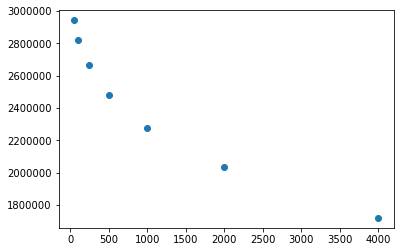

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

xs = [pair[0] for pair in scores]
ys = [pair[1] for pair in scores]
plt.scatter(xs,ys)
plt.show()

In [53]:
def create_cluster_df(kmeans_spark_df):
    return kmeans_spark_df.toPandas()[['asin', 'prediction']]\
            .rename(index=str, columns={"prediction": "clusterId"})

In [75]:
baby_cluster_df = create_cluster_df(models[6].transform(hash_combined_baby_meta_df))

In [76]:
baby_cluster_df.to_csv('baby_4000_cluster_df.csv')